# 1. Introduction
Contains all analysis to examine and standardise the space-time dynamics of the mtl-traject data

### Includes/To Add:
*Spatial*
- LISA of activities (where they end up and start
- directional LISA
- Heatmap across MTL
- Windrose on each region
- 2D-KDE (lat, lon) (start and end and overall trip)


*Temporal*
- (P)ACF for each mode and purpose
- CCF & CoD (problem: needs variance of a numeric variable)
- Divide into time of day and day of week
- Differencing for each mode and purpose
- Spaghetti plot and Boxplot of each mode and purpose
- ADF tests
- Detrending
- ARIMA for forecasting each mode &/or purpose, or time (seconds) and speed.  

*Spatial-Temporal*
- space-time slides for each type of activity (after Zhang & Cheng, in press)
- ST-(P)ACF for each mode and purpose
- ST-Detrending
- ST-ARIMA for forecasting each mode &/or purpose, or time (seconds) and speed.
- ** Windrose on each region with time (i.e. like a clock so only use the resultant for each hour) **
- Space-Time Interaction Tests


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns
import mplleaflet
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import libpysal
import pysal as ps # v2.0.0
import splot # spatial plotting for pysal 2.0.0
# from pysal.viz import splot
import shapely
import shapely.wkt
import scipy.stats as stats
import sys
import gpd_lite_toolbox as glt
import geoplot
import collections

from gpd_lite_toolbox.utils_carto import m_plot_dataframe, m_plot_multipolygon
sys.path.append('../utils')
import direction_functions
import spatial_functions
import temporal_functions

%matplotlib inline

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/windrose/windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() 

In [2]:
gdf = gpd.read_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8') # utf-8 needed to read french letters
mtl_region = gpd.read_file("../shapes/mtl_all_regions.json")
mtl_dissem = gpd.read_file("../shapes/mtl_dissem.geojson")
mtl_greater = gpd.read_file("../shapes/greater_montreal.geojson")
city_of_montreal = mtl_region.loc[(mtl_region.AIRE > 0) & (mtl_region.TYPE == 'Arrondissement')]
mtl_temp_prec = pd.read_csv('../data/mtl_temp_prec.csv')

In [3]:
mtl_greater['geometry'] = mtl_greater.buffer(0.01)

In [4]:
# outlier removal
gdf = gdf.loc[gdf.distance_m >= 50]
gdf = gdf.loc[gdf.seconds >= 60]
gdf = gdf.loc[gdf.distance_m <= 100000]
gdf = gdf.loc[gdf.seconds <= 10800]
gdf = gdf.reset_index(drop=True)

In [5]:
gdf.head()

id_trip  mode           purpose                  starttime  \
0     1547  None              None  2017-09-18 00:16:58-04:00   
1   308312  None              None  2017-09-18 02:17:46-04:00   
2   384772  None              None  2017-09-18 05:30:24-04:00   
3   150744   car  pick_up_a_person  2017-09-18 06:02:50-04:00   
4   199011  None              None  2017-09-18 06:18:40-04:00   

                     endtime  seconds    distance_m   direction  magnitude  \
0  2017-09-18 00:26:26-04:00      568   1530.222174  303.572980   0.019003   
1  2017-09-18 02:58:49-04:00     2463    324.869460  274.079216   0.313505   
2  2017-09-18 06:17:28-04:00     2824  32009.701647  130.691098   0.272104   
3  2017-09-18 06:17:12-04:00      862   9935.922336   85.310969   0.304086   
4  2017-09-18 06:27:44-04:00      544    563.806088   96.630699   0.255485   

  carddir  ...                    lda_word  temporal_c    precip  temperatur  \
0     WNW  ...                        None           0  0.000004   21.655905   
1       W  ...                        None           0  0.000000   20.182104   
2      SE  ...                        None           0  0.000000   18.353766   
3       E  ...  Monday_6, pick_up_a_person           1  0.000000   18.353766   
4       E  ...                        None           0  0.000000   18.353766   

                                            land_use  \
0                                               None   
1                                               None   
2                                               None   
3  ['residential', 'employment', 'diversified act...   
4                                               None   

                                      start_wgs  \
0  POINT (-73.65116600000005 45.54450099999979)   
1  POINT (-73.65098700000003 45.54449599999979)   
2  POINT (-73.79999600000002 45.63632099999982)   
3  POINT (-73.64638500000002 45.54628999999979)   
4  POINT (-73.74527300000005 45.55845599999979)   

                                        end_wgs  \
0   POINT (-73.65475300000004 45.5455209999998)   
1   POINT (-73.65475300000004 45.5455209999998)   
2  POINT (-73.62417100000005 45.53094099999978)   
3  POINT (-73.54531800000002 45.55066099999977)   
4  POINT (-73.72059400000005 45.55950099999978)   

                                     start_can  \
0  POINT (7624015.797731058 1247372.359122399)   
1  POINT (7624029.565886399 1247375.825611254)   
2  POINT (7609795.133960674 1253993.059622761)   
3  POINT (7624322.265039737 1247672.970059534)   
4  POINT (7616417.181546402 1246781.286979011)   

                                       end_can  \
0  POINT (7623710.593941391 1247402.423920968)   
1  POINT (7623710.593941391 1247402.423920968)   
2  POINT (7626500.696944128 1246510.141318924)   
3  POINT (7631863.767736516 1250414.940902869)   
4   POINT (7618260.407733496 1247444.31208628)   

                                            geometry  
0  LINESTRING (7624015.797731058 1247372.35912239...  
1  LINESTRING (7624029.565886399 1247375.82561125...  
2  (LINESTRING (7607307.107749196 1253237.7069476...  
3  LINESTRING (7624322.265039737 1247672.97005953...  
4  (LINESTRING (7616402.393582945 1246769.1996916...  

[5 rows x 28 columns]

## Globals

In [6]:
## get all the purposes and modes above 1000 trips
above1000_purpose = gdf.groupby(['purpose']).count()['id_trip'][gdf.groupby(['purpose']).count()['id_trip'] > 1000].index
above1000_mode = gdf.groupby(['mode']).count()['id_trip'][gdf.groupby(['mode']).count()['id_trip'] > 1000].index
ordered_days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

In [7]:
# turn the data back into datetime
gdf['starttime'] = gdf['starttime'].apply(gpd.pd.to_datetime)
gdf['endtime'] = gdf['endtime'].apply(gpd.pd.to_datetime)

# 2. Spatial Exploration
#### ToDo:
- Research 2-d KDE
- LISA

In [8]:
# convert the point columns back into a Point class
gdf['start_wgs'] = gdf['start_wgs'].apply(shapely.wkt.loads)
gdf['start_can'] = gdf['start_can'].apply(shapely.wkt.loads)
gdf['end_wgs'] = gdf['end_wgs'].apply(shapely.wkt.loads)
gdf['end_can'] = gdf['end_can'].apply(shapely.wkt.loads)

Exception ignored in: <function WKTReader.__del__ at 0x1195e69d8>
Traceback (most recent call last):
  File "/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/shapely/geos.py", line 243, in __del__
    self._lgeos.GEOSWKTReader_destroy(self._reader)
KeyboardInterrupt


KeyboardInterrupt: 

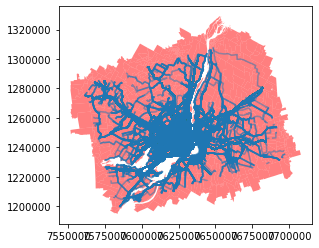

In [6]:
fig, ax = plt.subplots(1)
mtl_dissem.plot(ax=ax, alpha=.5, color='r')
gdf.plot(ax=ax, alpha=.5)

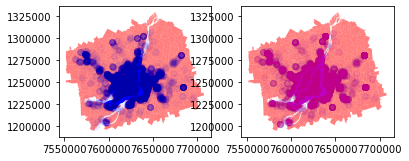

In [7]:
fig, axes = plt.subplots(1, 2)
mtl_dissem.plot(ax=axes[0], alpha=.5, color='r')
gpd.GeoSeries(gdf['start_can']).plot(ax=axes[0], alpha=.01, color='b')

mtl_dissem.plot(ax=axes[1], alpha=.5, color='r')
gpd.GeoSeries(gdf['end_can']).plot(ax=axes[1], alpha=.01, color='m')

In [8]:
gdf['purpose'].value_counts()

returning_home      27128
work                19241
leisure              9379
shops                8554
cafe                 3189
education            2830
pick_up_a_person     1592
other                1219
health               1061
not_available          25
Name: purpose, dtype: int64

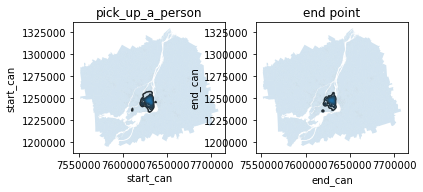

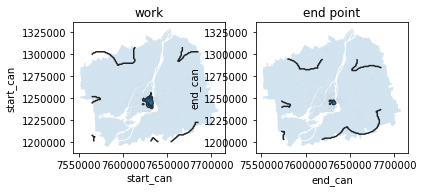

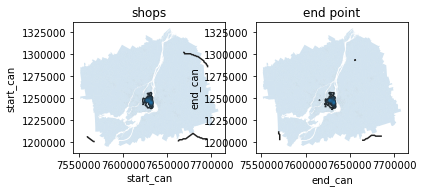

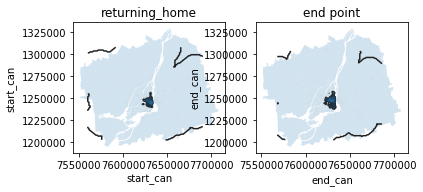

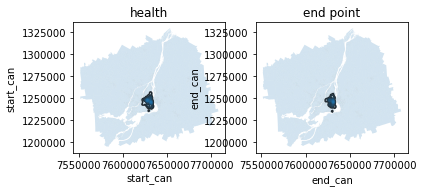

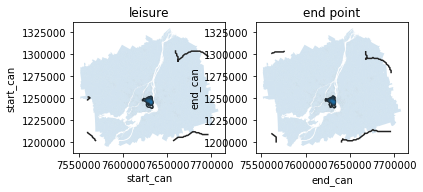

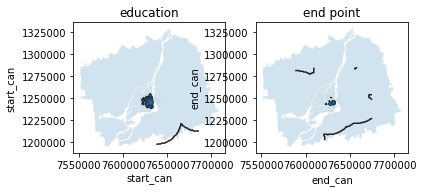

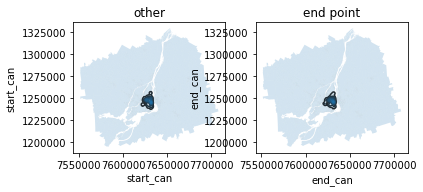

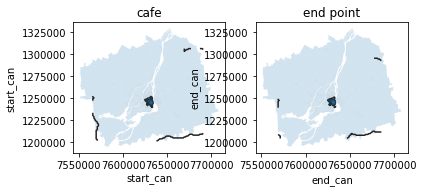

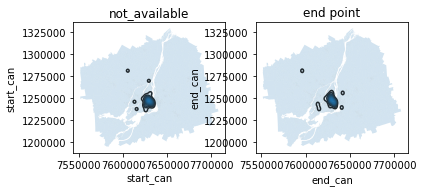

In [410]:
for i in gdf.purpose.unique():
    if i:
        fig, axes = plt.subplots(1,2, figsize=(6,5))
        axes[0].set_title(i)
        sns.kdeplot(gdf[gdf['purpose'] == i]['start_can'].apply(lambda row: row.x), gdf[gdf['purpose'] == i]['start_can'].apply(lambda row: row.y), ax=axes[0])
        mtl_dissem.plot(alpha=.2, ax=axes[0])
        axes[1].set_title("end point")
        sns.kdeplot(gdf[gdf['purpose'] == i]['end_can'].apply(lambda row: row.x), gdf[gdf['purpose'] == i]['end_can'].apply(lambda row: row.y), ax=axes[1])
        mtl_dissem.plot(alpha=.2, ax=axes[1])
        plt.show()

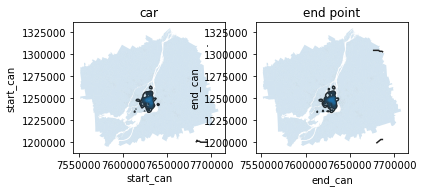

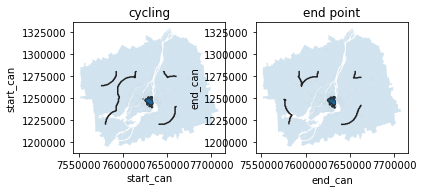

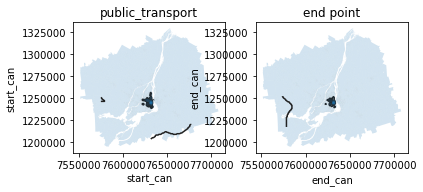

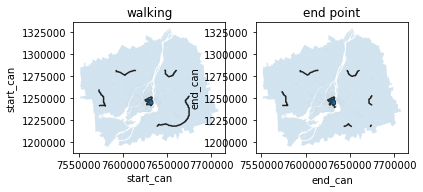

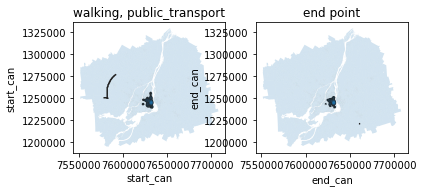

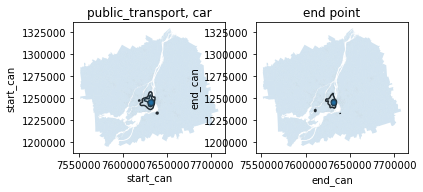

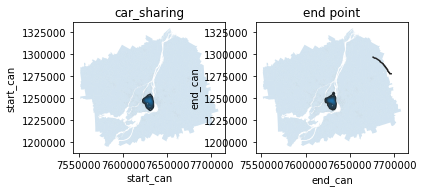

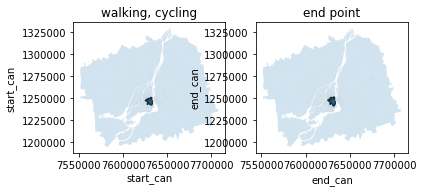

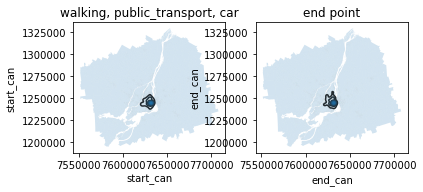

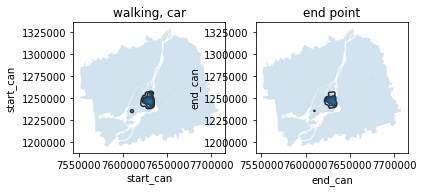

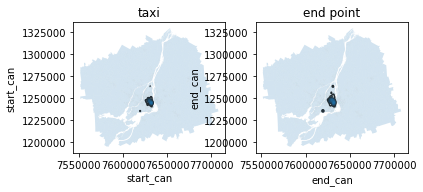

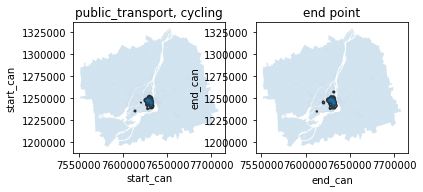

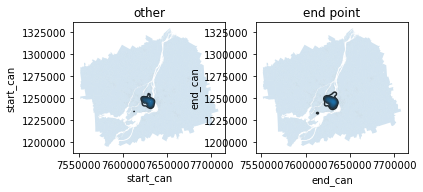

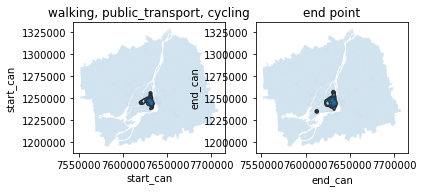

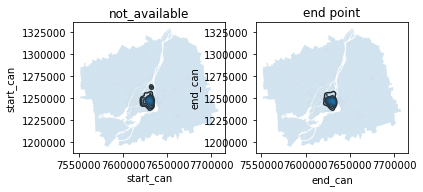

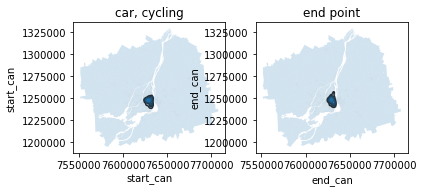

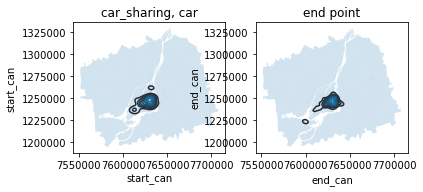

In [411]:
above_100 = gdf['mode'].value_counts()[gdf['mode'].value_counts() > 100].index

for i in above_100:
    if i:
        fig, axes = plt.subplots(1,2, figsize=(6,5))
        axes[0].set_title(i)
        sns.kdeplot(gdf[gdf['mode'] == i]['start_can'].apply(lambda row: row.x), gdf[gdf['mode'] == i]['start_can'].apply(lambda row: row.y), ax=axes[0])
        mtl_dissem.plot(alpha=.2, ax=axes[0])
        axes[1].set_title("end point")
        sns.kdeplot(gdf[gdf['mode'] == i]['end_can'].apply(lambda row: row.x), gdf[gdf['mode'] == i]['end_can'].apply(lambda row: row.y), ax=axes[1])
        mtl_dissem.plot(alpha=.2, ax=axes[1])
        plt.show()

In [23]:
# i = 'cycling'
# geoplot.kdeplot(gdf[gdf['mode'] == i], cmap='Reds', shade=True, clip=mtl_dissem, ax=ax)

#### gridifying the data

In [413]:
grid_points = gpd.GeoDataFrame(gdf.start_can)
grid_points.columns = ['geometry']
grid_points['count'] = 1
grid_points.head()

geometry  count
0  POINT (7624015.797731058 1247372.359122399)      1
1  POINT (7624029.565886399 1247375.825611254)      1
2  POINT (7609795.133960674 1253993.059622761)      1
3  POINT (7624322.265039737 1247672.970059534)      1
4  POINT (7616417.181546402 1246781.286979011)      1

In [414]:
grid = glt.gridify_data(grid_points, 2000,'count', method=np.min)  # Choose a method to aggregate point values in each grid cell

In [415]:
grid

geometry  count
0     POLYGON ((7563551.690888111 1278589.945025756,...     -1
1     POLYGON ((7563036.938705808 1277890.115485875,...      1
2     POLYGON ((7561565.859956 1275890.115485875, 75...      1
3     POLYGON ((7562105.662000987 1273890.115485875,...     -1
4     POLYGON ((7562665.020719151 1271890.115485875,...     -1
5     POLYGON ((7563224.379437316 1269890.115485875,...     -1
6     POLYGON ((7565551.690888111 1281309.038072627,...     -1
7     POLYGON ((7564508.017455614 1279890.115485875,...      1
8     POLYGON ((7563551.690888111 1277890.115485875,...     -1
9     POLYGON ((7563551.690888111 1275890.115485875,...      1
10    POLYGON ((7563551.690888111 1273890.115485875,...     -1
11    POLYGON ((7563551.690888111 1271890.115485875,...      1
12    POLYGON ((7563551.690888111 1269890.115485875,...     -1
13    POLYGON ((7563783.73815548 1267890.115485875, ...     -1
14    POLYGON ((7564343.096873645 1265890.115485875,...     -1
15    POLYGON ((7564902.45559181 1263890.115485875, ...     -1
16    POLYGON ((7565461.814309974 1261890.115485875,...     -1
17    POLYGON ((7567551.690888111 1284028.131119498,...     -1
18    POLYGON ((7567450.174955228 1283890.115485875,...     -1
19    POLYGON ((7565979.096205422 1281890.115485875,...     -1
20    POLYGON ((7565551.690888111 1279890.115485875,...     -1
21    POLYGON ((7565551.690888111 1277890.115485875,...      1
22    POLYGON ((7565551.690888111 1275890.115485875,...      1
23    POLYGON ((7565551.690888111 1273890.115485875,...      1
24    POLYGON ((7565551.690888111 1271890.115485875,...     -1
25    POLYGON ((7565551.690888111 1269890.115485875,...     -1
26    POLYGON ((7565551.690888111 1267890.115485875,...     -1
27    POLYGON ((7565551.690888111 1265890.115485875,...     -1
28    POLYGON ((7565551.690888111 1263890.115485875,...     -1
29    POLYGON ((7565551.690888111 1261890.115485875,...      1
...                                                 ...    ...
2529  POLYGON ((7689551.690888111 1235890.115485875,...     -1
2530  POLYGON ((7689551.690888111 1233890.115485875,...     -1
2531  POLYGON ((7689551.690888111 1231890.115485875,...     -1
2532  POLYGON ((7691598.571457725 1253890.115485875,...     -1
2533  POLYGON ((7691551.690888111 1253890.115485875,...      1
2534  POLYGON ((7691551.690888111 1251890.115485875,...      1
2535  POLYGON ((7691551.690888111 1249890.115485875,...     -1
2536  POLYGON ((7691551.690888111 1247890.115485875,...     -1
2537  POLYGON ((7691551.690888111 1245890.115485875,...     -1
2538  POLYGON ((7691551.690888111 1243890.115485875,...     -1
2539  POLYGON ((7691551.690888111 1241890.115485875,...     -1
2540  POLYGON ((7691551.690888111 1239890.115485875,...     -1
2541  POLYGON ((7691551.690888111 1237890.115485875,...     -1
2542  POLYGON ((7691551.690888111 1235890.115485875,...     -1
2543  POLYGON ((7691551.690888111 1233890.115485875,...     -1
2544  POLYGON ((7691551.690888111 1231890.115485875,...     -1
2545  POLYGON ((7694069.651260709 1245890.115485875,...     -1
2546  POLYGON ((7693551.690888111 1245890.115485875,...     -1
2547  POLYGON ((7693551.690888111 1243890.115485875,...     -1
2548  POLYGON ((7693551.690888111 1241890.115485875,...     -1
2549  POLYGON ((7693551.690888111 1239890.115485875,...     -1
2550  POLYGON ((7693551.690888111 1237890.115485875,...     -1
2551  POLYGON ((7693551.690888111 1235890.115485875,...     -1
2552  POLYGON ((7693551.690888111 1233890.115485875,...      1
2553  POLYGON ((7693551.690888111 1231890.115485875,...      1
2554  POLYGON ((7695920.014035121 1239890.115485875,...     -1
2555  POLYGON ((7695551.690888111 1239890.115485875,...     -1
2556  POLYGON ((7695551.690888111 1237890.115485875,...     -1
2557  POLYGON ((7695551.690888111 1235890.115485875,...      1
2558  POLYGON ((7695551.690888111 1233890.115485875,...      1

[2559 rows x 2 columns]

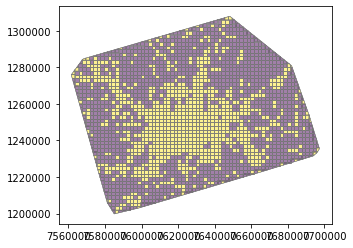

In [416]:
# could do this through time for spatio-temporal
m_plot_dataframe(grid, column='count', contour_poly_width=0.5, edgecolor="grey")

## group line into dissemination areas
This will then be used in LISA maps

In [63]:
from splot.esda import plot_local_autocorrelation, lisa_cluster


CPU times: user 4.57 s, sys: 182 ms, total: 4.75 s
Wall time: 4.78 s


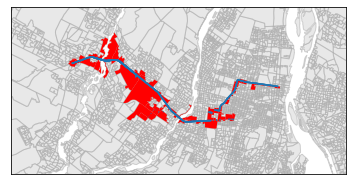

In [67]:
%%time
ind = 5
cross_section_joined = gpd.sjoin(gdf.iloc[:ind], mtl_dissem)

fig, ax = plt.subplots(1)
mtl_dissem.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=.5)
mtl_dissem.loc[mtl_dissem['DAUID'].isin(np.unique(cross_section_joined['DAUID'].values))].plot(ax=ax, color='r')
gpd.sjoin(gdf.iloc[:ind], mtl_region).plot(ax=ax, alpha=.8)
plt.ylim(1240000,1260000)
plt.xlim(7600000,7640000)
plt.xticks([]);
plt.yticks([]);
# plt.savefig("figures/example_passthrough.png", bbox_inches='tight')

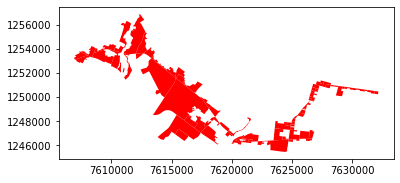

In [57]:
ind = 5
cross_section_joined = gpd.sjoin(gdf.iloc[None:ind], mtl_dissem)

mtl_dissem.loc[mtl_dissem['DAUID'].isin(np.unique(cross_section_joined['DAUID'].values))].plot(color='r')


In [58]:
mtl_dissem.loc[mtl_dissem['DAUID'].isin(np.unique(cross_section_joined['DAUID'].values))].DAUID.value_counts()

24660486    1
24660364    1
24650165    1
24650285    1
24662626    1
           ..
24662566    1
24650051    1
24662606    1
24730066    1
24662542    1
Name: DAUID, Length: 84, dtype: int64

### Note:
All data no subset

In [8]:
help(spatial_functions.get_intersecting_dissemination_ids)

Help on function get_intersecting_dissemination_ids in module spatial_functions:

get_intersecting_dissemination_ids(cross_section, dissemination_areas)
        takes a spatial join of the the montreal dissemination areas and a route
        and returns all the ids that the route passes through
    
    -------
    returns
    -------



In [11]:
ind = 1
cross_section_joined = gpd.sjoin(gdf.iloc[ind:ind+1], mtl_dissem)

In [13]:
len(gpd.sjoin(gdf.loc[gdf['mode'] == 'cycling'], mtl_dissem))

280327

In [230]:
cross_section_joined.groupby(['DAUID']).agg({'id_trip':'count'})['id_trip'].value_counts()

0    7043
1       3
Name: id_trip, dtype: int64

In [265]:
a = gpd.GeoDataFrame(cross_section_joined.groupby(['DAUID']).agg({'id_trip':'count', 'geometry':'first'}))

In [267]:
a.head()

id_trip                                           geometry
DAUID                                                               
24460109        0  (POLYGON ((7699731.028570508 1234478.742813654...
24460110        0  (POLYGON ((7698839.665731467 1237668.571444529...
24460112        0  (POLYGON ((7693178.071417456 1237598.974308138...
24460113        0  (POLYGON ((7697850.185684515 1237360.117141209...
24460114        0  (POLYGON ((7691942.297161575 1233736.914274367...

In [9]:
from shapely.geometry import Polygon
xmin,ymin,xmax,ymax = gdf.total_bounds
width = 5000
height = 5000
rows = int(np.ceil((ymax-ymin) /  height))
cols = int(np.ceil((xmax-xmin) / width))
XleftOrigin = xmin
XrightOrigin = xmin + width
YtopOrigin = ymax
YbottomOrigin = ymax- height
polygons = []
for i in range(cols):
    Ytop = YtopOrigin
    Ybottom =YbottomOrigin
    for j in range(rows):
        polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])) 
        Ytop = Ytop - height
        Ybottom = Ybottom - height
    XleftOrigin = XleftOrigin + width
    XrightOrigin = XrightOrigin + width

grid = gpd.GeoDataFrame({'geometry':polygons})

In [13]:
grid

geometry
0    POLYGON ((7561546.094221462 1307890.115485875,...
1    POLYGON ((7561546.094221462 1302890.115485875,...
2    POLYGON ((7561546.094221462 1297890.115485875,...
3    POLYGON ((7561546.094221462 1292890.115485875,...
4    POLYGON ((7561546.094221462 1287890.115485875,...
..                                                 ...
611  POLYGON ((7696546.094221462 1222890.115485875,...
612  POLYGON ((7696546.094221462 1217890.115485875,...
613  POLYGON ((7696546.094221462 1212890.115485875,...
614  POLYGON ((7696546.094221462 1207890.115485875,...
615  POLYGON ((7696546.094221462 1202890.115485875,...

[616 rows x 1 columns]

In [30]:
22*28

616

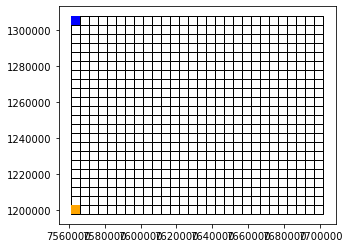

In [31]:
fig, ax = plt.subplots(1)
grid.plot(ax=ax, edgecolor='k', color='white')
grid.loc[0:0].plot(ax=ax, color='b')
grid.loc[21:21].plot(ax=ax, color='orange')

In [324]:
def make_images():
    return

In [34]:
xy_grid = []
for x in range(1,29):
    for y in range(22, 0, -1):
        xy_grid.append((x,y))
grid['coord'] = pd.Series(xy_grid)
xy_coords = grid.coord.apply(pd.Series)
xy_coords.columns = ['x','y']
grid_xy = gpd.GeoDataFrame(pd.concat([xy_coords, grid], axis=1))
grid_xy.drop('coord', inplace=True, axis=1)

In [37]:
# grid_xy.to_file("../shapes/grid_xy_cnn.shp")

In [44]:
grid_xy_cnn =gpd.read_file("../shapes/grid_xy_cnn.shp")

In [ ]:
# gdf == done
# city == 
# non-city == 
# rush == 
# non-rush == 

In [70]:
gdf.col

id_trip              mode           purpose                 starttime  \
0          1547              None              None 2017-09-18 00:16:58-04:00   
1        308312              None              None 2017-09-18 02:17:46-04:00   
2        384772              None              None 2017-09-18 05:30:24-04:00   
3        150744               car  pick_up_a_person 2017-09-18 06:02:50-04:00   
4        199011              None              None 2017-09-18 06:18:40-04:00   
...         ...               ...               ...                       ...   
177933    17219              None              None 2017-10-17 23:44:12-04:00   
177934    58004  public_transport    returning_home 2017-10-17 23:44:38-04:00   
177935   132248              None              None 2017-10-17 23:45:47-04:00   
177936   344413              None              None 2017-10-17 23:47:48-04:00   
177937   236906              None              None 2017-10-17 23:50:08-04:00   

                         endtime  seconds    distance_m   direction  \
0      2017-09-18 00:26:26-04:00      568   1530.222174  303.572980   
1      2017-09-18 02:58:49-04:00     2463    324.869460  274.079216   
2      2017-09-18 06:17:28-04:00     2824  32009.701647  130.691098   
3      2017-09-18 06:17:12-04:00      862   9935.922336   85.310969   
4      2017-09-18 06:27:44-04:00      544    563.806088   96.630699   
...                          ...      ...           ...         ...   
177933 2017-10-17 23:45:19-04:00       67     84.489962  252.900364   
177934 2017-10-17 23:53:18-04:00      520   2086.587283  347.722806   
177935 2017-10-17 23:51:51-04:00      364    174.552338   49.180282   
177936 2017-10-17 23:57:29-04:00      581    592.379501   33.844122   
177937 2017-10-17 23:51:43-04:00       95    175.219504  303.079719   

        magnitude carddir  ...                    lda_word  temporal_c  \
0        0.019003     WNW  ...                        None           0   
1        0.313505       W  ...                        None           0   
2        0.272104      SE  ...                        None           0   
3        0.304086       E  ...  Monday_6, pick_up_a_person           1   
4        0.255485       E  ...                        None           0   
...           ...     ...  ...                         ...         ...   
177933   0.488491     WSW  ...                        None           0   
177934   0.339765     NNW  ...  Tuesday_23, returning_home           1   
177935   0.031250      NE  ...                        None           0   
177936   0.475605      NE  ...                        None           0   
177937   0.020000     WNW  ...                        None           0   

          precip  temperatur  \
0       0.000004   21.655905   
1       0.000000   20.182104   
2       0.000000   18.353766   
3       0.000000   18.353766   
4       0.000000   18.353766   
...          ...         ...   
177933  0.000080   10.518091   
177934  0.000080   10.518091   
177935  0.000080   10.518091   
177936  0.000080   10.518091   
177937  0.000080   10.518091   

                                                 land_use  \
0                                                    None   
1                                                    None   
2                                                    None   
3       ['residential', 'employment', 'diversified act...   
4                                                    None   
...                                                   ...   
177933                                               None   
177934  ['park', 'mixed', 'employment', 'diversified a...   
177935                                               None   
177936                                               None   
177937                                               None   

                                           start_wgs  \
0       POINT (-73.65116600000005 45.54450099999979)   
1       POINT (-73.65098700000003 45.54449599999979)   
2      

In [71]:
purp_gdf = gdf.loc[np.where(gdf.purpose)]
purp_city = purp_gdf.loc[(purp_gdf.start_down == 1)|(purp_gdf.end_downto == 1)]
purp_noncity = purp_gdf.loc[(purp_gdf.start_down != 1)&(purp_gdf.end_downto != 1)]

purp_rush = purp_gdf.loc[(purp_gdf.startrush == 1)|(purp_gdf.endrush == 1)|(purp_gdf.thrurush == 1)]
purp_nonrush = purp_gdf.loc[(purp_gdf.startrush != 1)&(purp_gdf.endrush != 1)&(purp_gdf.thrurush != 1)]

In [74]:
all_npz = []
all_ys = []
for i, row in purp_city.iterrows():
    cross_section_joined = gpd.sjoin(purp_city.loc[i:i], grid_xy_cnn, how='right')
    cross_section_joined = gpd.GeoDataFrame(cross_section_joined.groupby([cross_section_joined.index]).agg({'id_trip':'count', 'geometry':'first', 'x':'first','y':'first'}))
    if i % 7000 ==0:
        print("7000!")
    x = np.array(cross_section_joined.id_trip)
    all_npz.append(x)
    

7000!


KeyboardInterrupt: 

In [ ]:
len(all_npz)

In [ ]:
all_npz_final = np.array(all_npz) 
# all_npz_final

In [ ]:
np.savez('analysis_results/city_gdf_images.npz', all_npz_final)

In [ ]:
# npzfile = np.load('analysis_results/city_pur_images.npz')
npzfile.files

In [64]:
npzfile['arr_0'].shape

(73029, 616)

In [8]:
%%time
# time for 1000 == 7 mins
# total vals == 185285
chosen_mode = 'car'
total_dissem_arr = [] # dissemination area
total_reg_arr = [] # regions
total_code_arr = [] # montreal island codes
for i in range(501):
    cross_section_joined = gpd.sjoin(gdf.loc[gdf['mode'] == chosen_mode].iloc[i:i+1], mtl_dissem)
    dissem_arr, reg_arr = spatial_functions.get_intersecting_dissemination_ids(cross_section_joined, mtl_dissem)
    if i % 100 == 0:
        print(i)
    total_dissem_arr.extend(dissem_arr)
    total_reg_arr.extend(reg_arr)

0


KeyboardInterrupt: 

In [18]:
len(total_dissem_arr)

24357

In [19]:
collections.Counter(total_dissem_arr)

Counter({'24662610': 33,
         '24662627': 45,
         '24662606': 23,
         '24660492': 15,
         '24662619': 47,
         '24660256': 45,
         '24662087': 14,
         '24662001': 13,
         '24660416': 52,
         '24662004': 7,
         '24662605': 41,
         '24660242': 23,
         '24660458': 53,
         '24662089': 13,
         '24660243': 20,
         '24660415': 45,
         '24660362': 39,
         '24662043': 17,
         '24661768': 13,
         '24660491': 62,
         '24662109': 8,
         '24662003': 6,
         '24661672': 8,
         '24662042': 12,
         '24662607': 46,
         '24660364': 40,
         '24662045': 13,
         '24662077': 7,
         '24660360': 42,
         '24660257': 15,
         '24662626': 29,
         '24662608': 24,
         '24662069': 6,
         '24660363': 7,
         '24660359': 46,
         '24661765': 11,
         '24662611': 43,
         '24650440': 10,
         '24650640': 14,
         '24730120': 7,
        

In [20]:
collections.Counter(total_reg_arr)

Counter({'2466023': 811,
         '2465005': 101,
         '2473010': 20,
         '2473005': 34,
         '2473015': 23,
         '2457030': 5,
         '2456083': 5,
         '2455057': 5,
         '2455065': 3,
         '2457010': 4,
         '2457035': 8,
         '2457005': 6,
         '2467015': 32,
         '2458227': 136,
         '2458033': 33,
         '2466047': 32,
         '2466087': 57,
         '2472005': 15,
         '2459010': 4,
         '2459015': 2,
         '2458007': 46,
         '2466072': 96,
         '2473020': 11,
         '2473025': 5,
         '2473030': 7,
         '2466007': 28,
         '2466032': 84,
         '2458012': 26,
         '2466142': 16,
         '2466097': 47,
         '2467050': 9,
         '2467802': 11,
         '2466102': 17,
         '2460013': 22,
         '2475017': 8,
         '2474005': 15,
         '2458037': 10,
         '2464008': 18,
         '2466107': 15,
         '2466062': 4,
         '2466058': 10,
         '2467035': 10,
   

In [21]:
mtl_dissem['freq_dissem_counts'] = mtl_dissem.apply(lambda row: collections.Counter(total_dissem_arr)[row.DAUID], axis=1)
mtl_region['freq_reg_counts'] = mtl_region.apply(lambda row: collections.Counter(total_reg_arr)[row.CSDUID], axis=1)

In [22]:
mtl_dissem

DAUID CDUID                 CDNAME CDTYPE   CSDUID      CSDNAME  \
0     24700071  2470  Beauharnois-Salaberry    MRC  2470022  Beauharnois   
1     24650694  2465                  Laval      T  2465005        Laval   
2     24662467  2466                Montral      T  2466023      Montral   
3     24662706  2466                Montral      T  2466023      Montral   
4     24580036  2458              Longueuil      T  2458227    Longueuil   
...        ...   ...                    ...    ...      ...          ...   
7302  24650141  2465                  Laval      T  2465005        Laval   
7303  24661823  2466                Montral      T  2466023      Montral   
7304  24670143  2467             Roussillon    MRC  2467050   Chteauguay   
7305  24640247  2464            Les Moulins    MRC  2464008   Terrebonne   
7306  24661438  2466                Montral      T  2466023      Montral   

     CSDTYPE   CCSUID      CCSNAME ERUID  ...  CMANAME CMATYPE SACCODE  \
0          V  2470022  Beauharnois  2435  ...  Montral       B     462   
1          V  2465005        Laval  2445  ...  Montral       B     462   
2          V  2466023      Montral  2440  ...  Montral       B     462   
3          V  2466023      Montral  2440  ...  Montral       B     462   
4          V  2458227    Longueuil  2435  ...  Montral       B     462   
...      ...      ...          ...   ...  ...      ...     ...     ...   
7302       V  2465005        Laval  2445  ...  Montral       B     462   
7303       V  2466023      Montral  2440  ...  Montral       B     462   
7304       V  2467050   Chteauguay  2435  ...  Montral       B     462   
7305       V  2464008   Terrebonne  2450  ...  Montral       B     462   
7306       V  2466023      Montral  2440  ...  Montral       B     462   

     SACTYPE       CTUID   CTNAME PRUID          PRNAME  \
0          1  4620777.02  0777.02    24  Quebec / Qubec   
1          1  4620659.10  0659.10    24  Quebec / Qubec   
2          1  4620416.01  0416.01    24  Quebec / Qubec   
3          1  4620619.00  0619.00    24  Quebec / Qubec   
4          1  4620880.00  0880.00    24  Quebec / Qubec   
...      ...         ...      ...   ...             ...   
7302       1  4620638.04  0638.04    24  Quebec / Qubec   
7303       1  4620176.00  0176.00    24  Quebec / Qubec   
7304       1  4620802.00  0802.00    24  Quebec / Qubec   
7305       1  4620700.03  0700.03    24  Quebec / Qubec   
7306       1  4620172.00  0172.00    24  Quebec / Qubec   

                                               geometry freq_dissem_counts  
0     (POLYGON ((7614920.211429008 1216981.757154953...                  1  
1     (POLYGON ((7612254.411394808 1252883.785716854...                  0  
2     (POLYGON ((7618928.159977993 1242899.359981268...                  0  
3     (POLYGON ((7622684.02860707 1251714.83427309, ...                  1  
4     (POLYGON ((7635632.045734551 1249192.339954694...                  6  
...                                                 ...                ...  
7302  (POLYGON ((7619469.471425552 1247941.425697241...                  1  
7303  (POLYGON ((7629522.740002374 1247945.368623123...                  0  
7304  (POLYGON ((7621117.377171299 1226897.425738305...                  0  
7305  (POLYGON ((7620465.720018841 1265280.120023799...                  0  
7306  (POLYGON ((7629494.214329178 1247074.291384043...                 10  

[7307 rows x 23 columns]

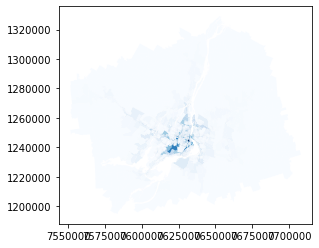

In [23]:
mtl_dissem.plot('freq_dissem_counts', cmap='Blues')

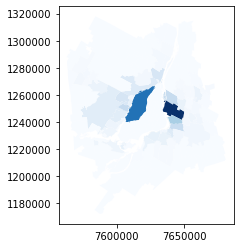

In [24]:
mtl_region.plot('freq_reg_counts', cmap='Blues')

### Notes on LISA:
- maybe only above a certain threshold
- global stat for dispersion 

In [25]:
wq = ps.lib.weights.contiguity.Queen.from_dataframe(mtl_dissem)

In [26]:
y = mtl_dissem['freq_dissem_counts'].values

In [27]:
moran_loc = ps.explore.esda.Moran_Local(y, wq)

('WARNING: ', 3776, ' is an island (no neighbors)')
('WARNING: ', 6845, ' is an island (no neighbors)')


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pysal/explore/esda/moran.py:895: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


(<Figure size 864x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123430160>)

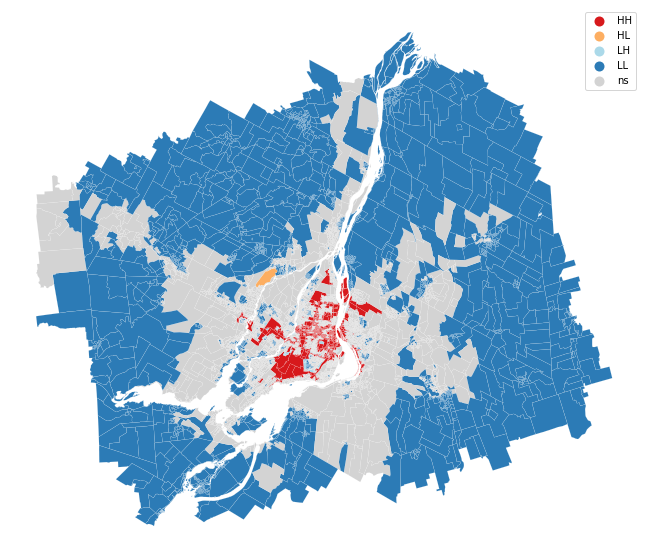

In [28]:
fig, ax = plt.subplots(1, figsize=(12,10))
lisa_cluster(moran_loc, mtl_dissem, ax=ax)

## faster LISA plotting

Faster because doesn't loop through every single trip

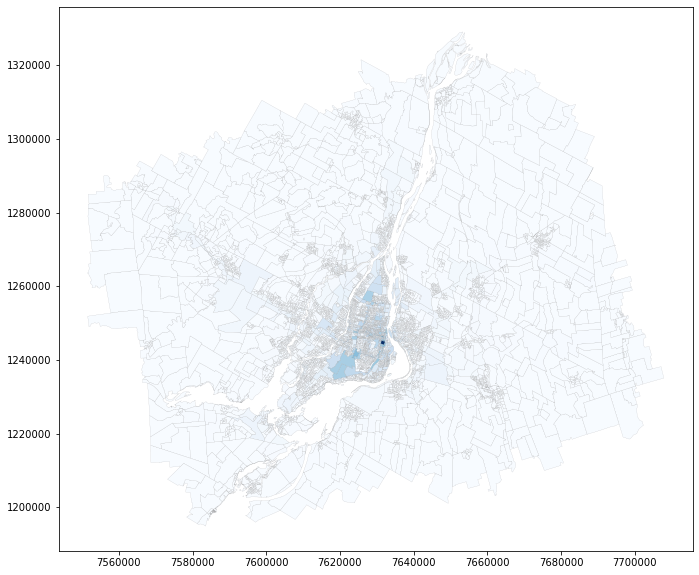

In [51]:
fig, ax = plt.subplots(1, figsize=(12,10))
mtl_dissem.plot('freq_dissem_counts', linewidth=.1, edgecolor='0.5', cmap='Blues', ax=ax)


In [54]:
def plot_counts(var, purpose=True, cmap='Reds', return_df=False):
    """
    function for plotting a map of counts of a variable
    """
    if purpose:
        assert var in data['purpose'].unique(), "var: \'%s\' is not in the purpose column of the dataframe" % (var)
        joined_data = gpd.sjoin(gdf.loc[gdf['purpose'] == var], mtl_dissem)
    else:
        assert var in data['mode'].unique(), "var: \'%s\' is not in the mode column of the dataframe" % (var)
        joined_data = gpd.sjoin(gdf.loc[gdf['mode'] == var], mtl_dissem)        
        
    mtl_dissem['freq_dissem_counts'] = mtl_dissem.apply(lambda row: joined_data.DAUID.value_counts()[row.DAUID] if row.DAUID in joined_data.DAUID.unique() else 0, axis=1)
    
    fig, ax = plt.subplots(1, figsize=(12,10))
    mtl_dissem.plot('freq_dissem_counts', linewidth=.1, edgecolor='0.5', cmap=cmap, ax=ax)
    plt.title(var)
    
    if return_df:
        return mtl_dissem

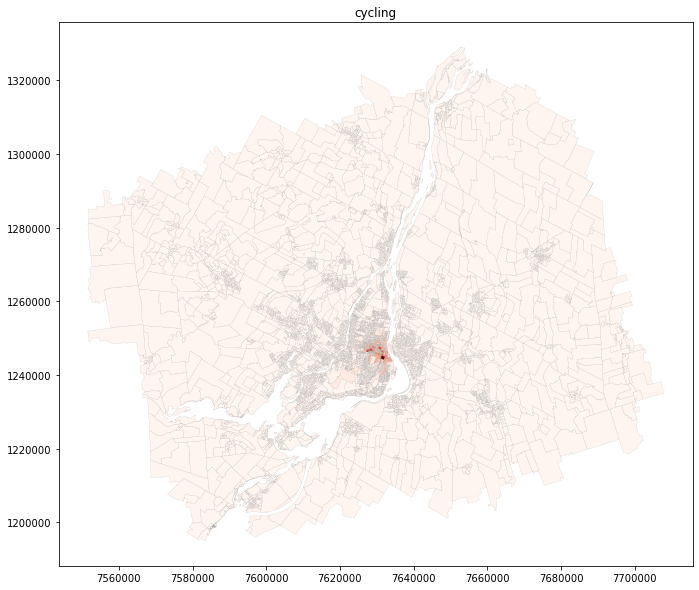

In [53]:
spatial_functions.plot_counts('cycling')

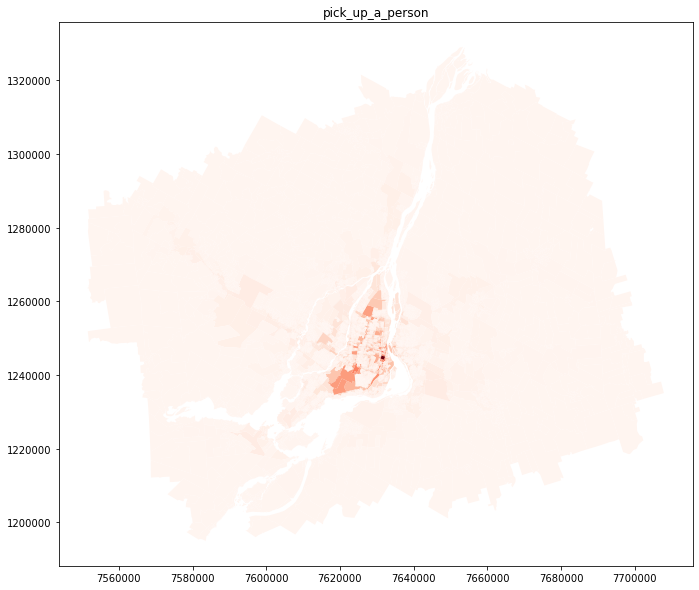

In [31]:
plot_counts('pick_up_a_person', False)

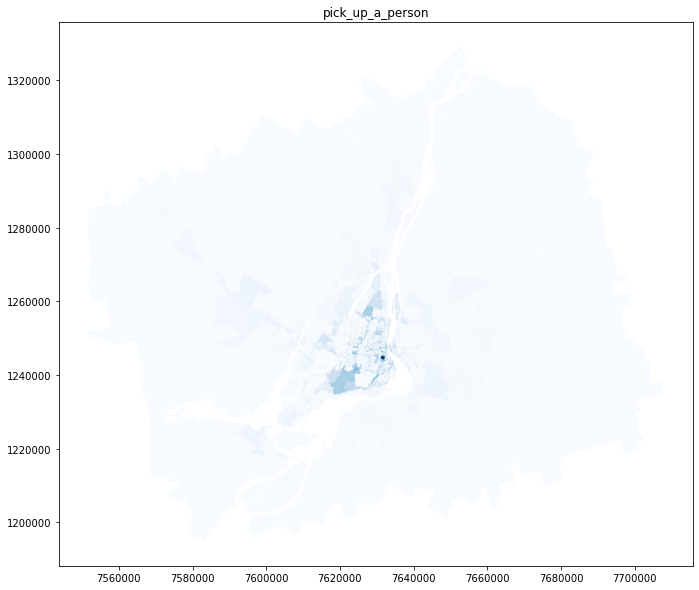

In [298]:
plot_counts('pick_up_a_person', False, 'Blues')

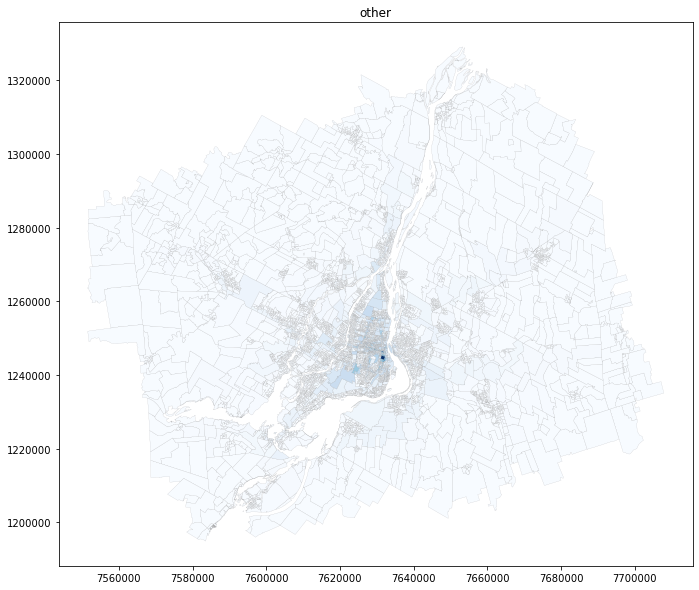

In [56]:
joined_data = plot_counts('other', False, 'Blues', True)

In [58]:
all(mtl_dissem == joined_data)

True

In [59]:
y = joined_data['freq_dissem_counts'].values

In [60]:
moran_loc = ps.explore.esda.Moran_Local(y, wq)

(<Figure size 864x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1249c15f8>)

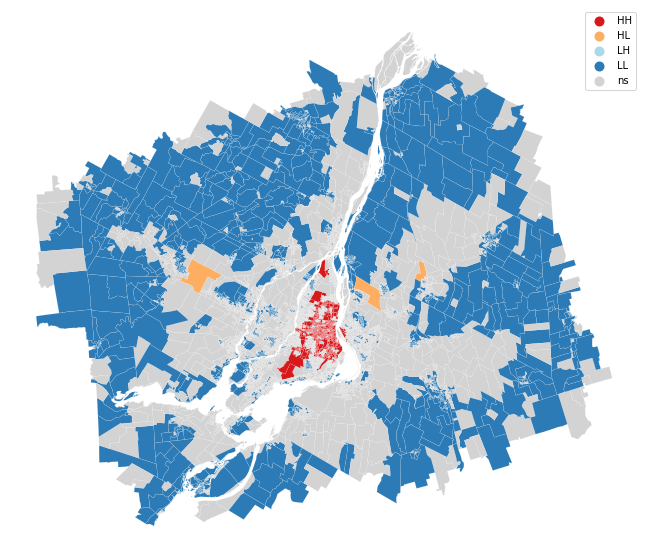

In [61]:
fig, ax = plt.subplots(1, figsize=(12,10))
lisa_cluster(moran_loc, mtl_dissem, ax=ax)

# 3. Temporal Exploration

### To-Do:
- groupby time

In [9]:
# turn the data back into datetime
gdf['starttime'] = gdf['starttime'].apply(gpd.pd.to_datetime)
gdf['endtime'] = gdf['endtime'].apply(gpd.pd.to_datetime)

In [13]:
gdf.head()

id_trip  mode           purpose                 starttime  \
0     1547  None              None 2017-09-18 00:16:58-04:00   
1   308312  None              None 2017-09-18 02:17:46-04:00   
2   384772  None              None 2017-09-18 05:30:24-04:00   
3   150744   car  pick_up_a_person 2017-09-18 06:02:50-04:00   
4   199011  None              None 2017-09-18 06:18:40-04:00   

                    endtime  seconds    distance_m   direction  magnitude  \
0 2017-09-18 00:26:26-04:00      568   1530.222174  303.572980   0.019003   
1 2017-09-18 02:58:49-04:00     2463    324.869460  274.079216   0.313505   
2 2017-09-18 06:17:28-04:00     2824  32009.701647  130.691098   0.272104   
3 2017-09-18 06:17:12-04:00      862   9935.922336   85.310969   0.304086   
4 2017-09-18 06:27:44-04:00      544    563.806088   96.630699   0.255485   

  carddir                                     start_wgs  \
0     WNW  POINT (-73.65116600000005 45.54450099999979)   
1       W  POINT (-73.65098700000003 45.54449599999979)   
2      SE  POINT (-73.79999600000002 45.63632099999982)   
3       E  POINT (-73.64638500000002 45.54628999999979)   
4       E  POINT (-73.74527300000005 45.55845599999979)   

                                        end_wgs  \
0   POINT (-73.65475300000004 45.5455209999998)   
1   POINT (-73.65475300000004 45.5455209999998)   
2  POINT (-73.62417100000005 45.53094099999978)   
3  POINT (-73.54531800000002 45.55066099999977)   
4  POINT (-73.72059400000005 45.55950099999978)   

                                     start_can  \
0  POINT (7624015.797731058 1247372.359122399)   
1  POINT (7624029.565886399 1247375.825611254)   
2  POINT (7609795.133960674 1253993.059622761)   
3  POINT (7624322.265039737 1247672.970059534)   
4  POINT (7616417.181546402 1246781.286979011)   

                                       end_can  \
0  POINT (7623710.593941391 1247402.423920968)   
1  POINT (7623710.593941391 1247402.423920968)   
2  POINT (7626500.696944128 1246510.141318924)   
3  POINT (7631863.767736516 1250414.940902869)   
4   POINT (7618260.407733496 1247444.31208628)   

                                            geometry  
0  LINESTRING (7624015.797731058 1247372.35912239...  
1  LINESTRING (7624029.565886399 1247375.82561125...  
2  (LINESTRING (7607307.107749196 1253237.7069476...  
3  LINESTRING (7624322.265039737 1247672.97005953...  
4  (LINESTRING (7616402.393582945 1246769.1996916...

In [14]:
gdf['hour'] = gdf.starttime.apply(lambda tm: tm.hour)

Text(0, 0.5, 'Hour of day')

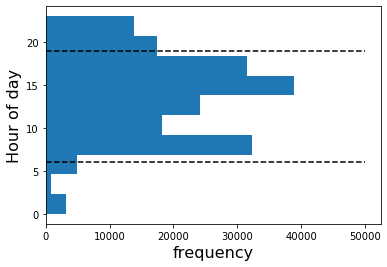

In [380]:
plt.hist(gdf.hour, orientation='horizontal')
plt.xlabel("frequency", size=16)
plt.hlines(6,0,50000, linestyles='--')
plt.hlines(19,0,50000, linestyles='--')
plt.ylabel("Hour of day", size=16)

#### groupby ideas:
- day and car-dir
- day and (group by space)
- purpose and day then plot timeseries

### Group-By Time (all days)

In [5]:
time_group = '1h'
count_mode = gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq=time_group), 'mode']).count()
count_mode.reset_index(inplace=True)
count_mode.set_index('starttime', inplace=True)

count_purpose = gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq=time_group), 'purpose']).count()
count_purpose.reset_index(inplace=True)
count_purpose.set_index('starttime', inplace=True)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


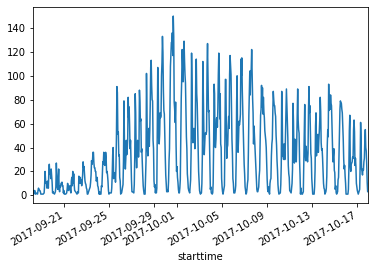

In [8]:
the_mode = 'car'
count_mode.loc[count_mode['mode'] == the_mode]['id_trip'].plot()

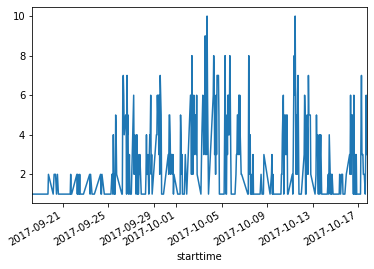

In [10]:
the_purpose = 'health'
count_purpose.loc[count_purpose['purpose'] == the_purpose]['id_trip'].plot()

### Group-By Time (mean of all days)

In [5]:
## look at my home-made function to group the data by units and purpose
help(temporal_functions.group_purpose_24hr)

Help on function group_purpose_24hr in module temporal_functions:

group_purpose_24hr(data, purpose, column='starttime', time_grp=1, units='h')
    Groups the data by purpose for a given time period and then takes the average across a 24-day.
    Note: doesn't divide the data into week/weekends
    
    Paramaters:
    -----------
    data : geopandas.GeoDataFrame
        contains the MTL-Trajet information
    purpose : string
        the purpose of the trip entered by user
    columns : string
        column containing the 
    time : int or string
        time to group each day into
    units : string
        units for the time (i.e. h or min)



In [32]:
def group_purpose_24hr(data, purpose, column='starttime', time_grp=1 ,units='h'):
    """
    Groups the data by purpose for a given time period and then takes the average across a 24-day.
    Note: doesn't divide the data into week/weekends
    
    Paramaters:
    -----------
    data : geopandas.GeoDataFrame
        contains the MTL-Trajet information
    purpose : string
        the purpose of the trip entered by user
    columns : string
        column containing the 
    time : int or string
        time to group each day into
    units : string
        units for the time (i.e. h or min)
        
    """
    unit_vals = {} # dictionary for holding the mean value at each time unit
    
    try:
        column = str(column)
        time_grp = int(time_grp)
        assert column in data.columns, "\'%s\' not found as a column in data" % column
        assert 'purpose' in data.columns, "\'purpose\' not found as a column in data"
    except:
        raise TypeError ("invalid input")
    
    
    
    purpose_group = data.set_index(column).groupby([gpd.pd.Grouper(freq=str(time_grp)+units), 'purpose']).count()
    purpose_group = purpose_group.reset_index()
    purpose_group = purpose_group.set_index(column)
    
    if units == 'h':
        num = int(np.floor(24 / int(time_grp)))
#         periods = np.arange(int(24/num)-1,24, time_grp)
        ind_time_units = purpose_group.index.hour
    elif units == 'min':
        num = int(np.floor((1440) / int(time_grp)))
#         periods = np.arange(int(1440/num)-1,1440, time_grp)
        ind_time_units = purpose_group.index.minute
    else:
        return print("please enter appropriate units: \'h\' or \'min\'")

    for tm in purpose_group.index.hour.unique():
        tm_mean = purpose_group.loc[(ind_time_units == tm) & (purpose_group['purpose'] == purpose)]
        tm_mean = tm_mean[tm_mean.columns[-1]].mean()
        unit_vals[tm] = tm_mean
    return unit_vals

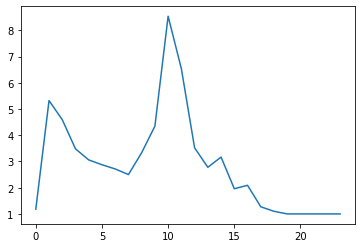

In [9]:
# crashes a lot
cafe_tprof = group_purpose_24hr(gdf, 'pick_up_a_person', time_grp=1, units='h')
plt.plot(list(cafe_tprof.values()))

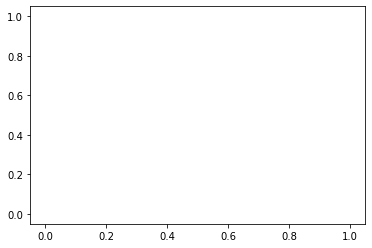

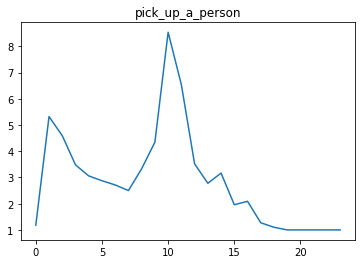

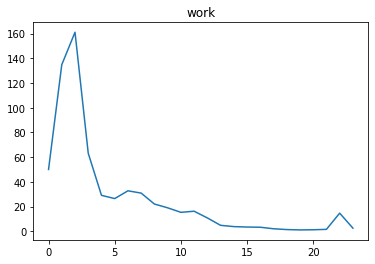

In [ ]:
for purpose in gdf.purpose.unique():
    cafe_tprof = group_purpose_24hr(gdf, purpose, time_grp=1, units='h')
    plt.plot(list(cafe_tprof.values()))
    plt.title(purpose)
    plt.show()
    plt.close()

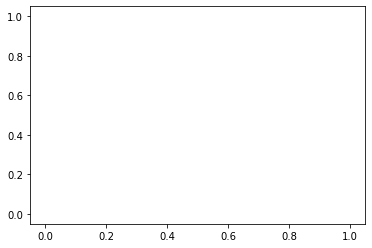

# 4. Space-Time methods

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/geopandas/plotting.py:413: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


hour
0     AxesSubplot(0.256296,0.125;0.512408x0.755)
1     AxesSubplot(0.239737,0.125;0.545526x0.755)
2      AxesSubplot(0.21574,0.125;0.593521x0.755)
3     AxesSubplot(0.125,0.162125;0.775x0.680749)
4     AxesSubplot(0.251922,0.125;0.521157x0.755)
5     AxesSubplot(0.190906,0.125;0.643187x0.755)
6       AxesSubplot(0.21759,0.125;0.58982x0.755)
7      AxesSubplot(0.20021,0.125;0.624581x0.755)
8     AxesSubplot(0.196108,0.125;0.632784x0.755)
9     AxesSubplot(0.212949,0.125;0.599102x0.755)
10    AxesSubplot(0.175881,0.125;0.673239x0.755)
11    AxesSubplot(0.199698,0.125;0.625604x0.755)
12    AxesSubplot(0.187244,0.125;0.650512x0.755)
13    AxesSubplot(0.195135,0.125;0.634731x0.755)
14    AxesSubplot(0.193344,0.125;0.638311x0.755)
15    AxesSubplot(0.181905,0.125;0.661189x0.755)
16    AxesSubplot(0.188843,0.125;0.647314x0.755)
17    AxesSubplot(0.203159,0.125;0.618682x0.755)
18     AxesSubplot(0.198545,0.125;0.62791x0.755)
19    AxesSubplot(0.221888,0.125;0.581224x0.755)
20    AxesSubpl

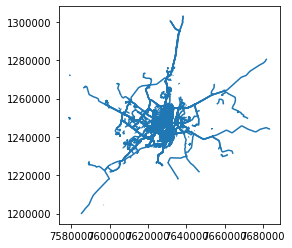

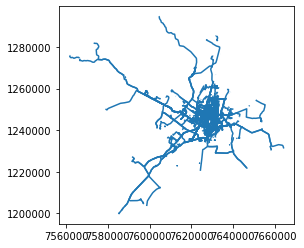

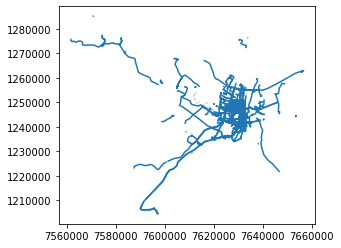

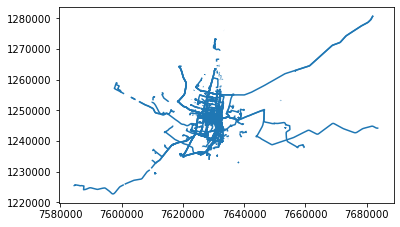

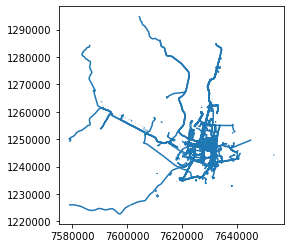

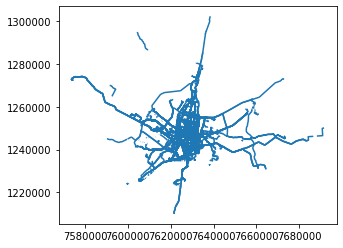

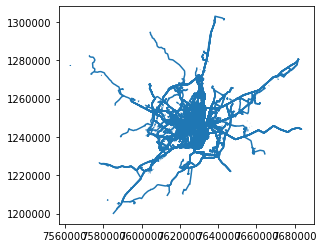

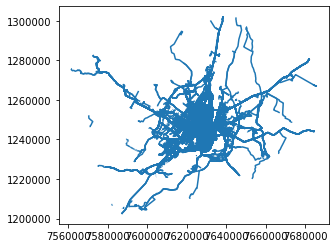

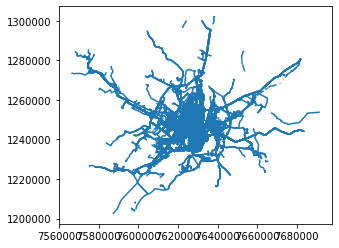

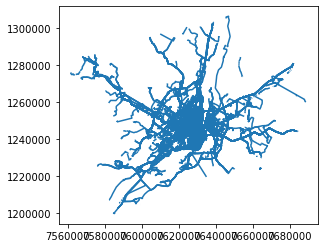

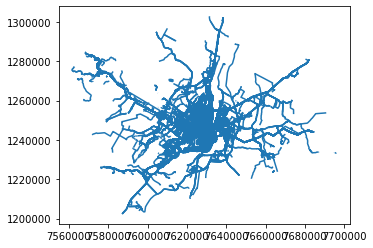

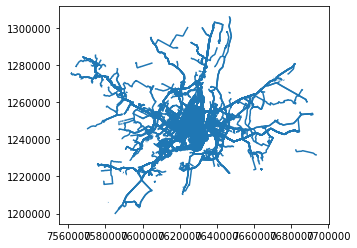

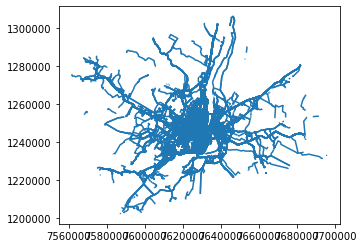

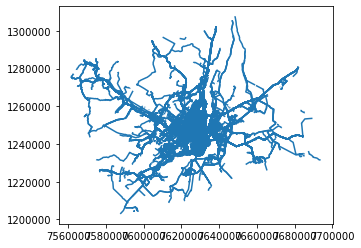

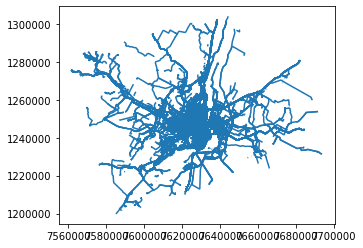

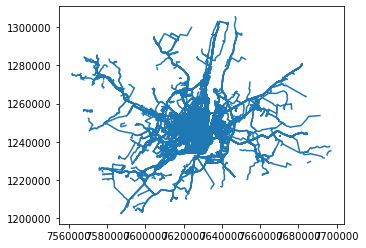

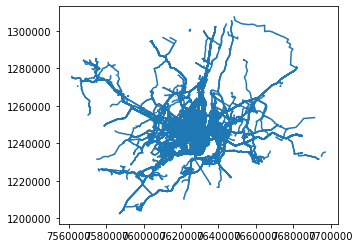

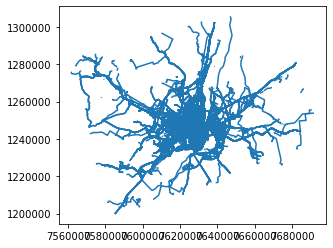

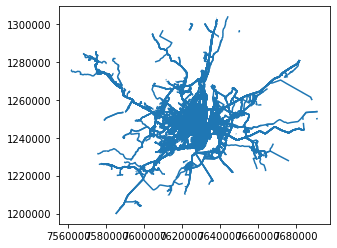

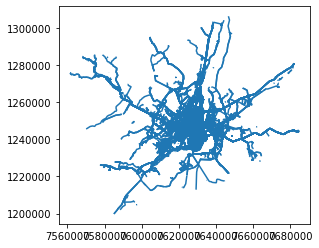

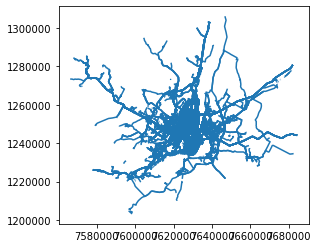

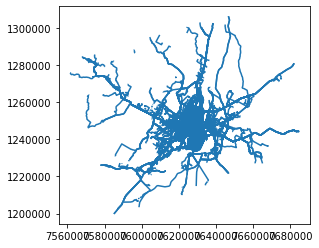

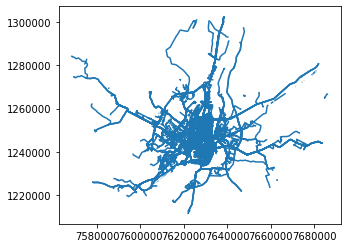

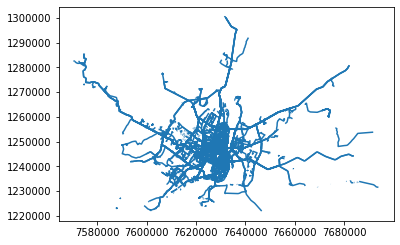

In [15]:
gdf.set_index('starttime').groupby('hour').plot();
# plt.title()

## Networks

In [9]:
%%time
## change to pysal
ntw = ps.explore.spaghetti.Network(gdf.loc[:10])
W = ntw.contiguityweights()
W

CPU times: user 141 ms, sys: 7.33 ms, total: 149 ms
Wall time: 157 ms


In [8]:
gdf.loc[:10]

id_trip  mode           purpose               starttime  \
0      1547  None              None  2017-09-18 04:16:58UTC   
1    308312  None              None  2017-09-18 06:17:46UTC   
2    384772  None              None  2017-09-18 09:30:24UTC   
3    150744   car  pick_up_a_person  2017-09-18 10:02:50UTC   
4    199011  None              None  2017-09-18 10:18:40UTC   
5    421155  None              None  2017-09-18 10:42:13UTC   
6     29064  None              None  2017-09-18 10:47:52UTC   
7    203781  None              None  2017-09-18 10:53:49UTC   
8    273549  None              None  2017-09-18 10:54:50UTC   
9    314196  None              None  2017-09-18 10:57:01UTC   
10   224569  None              None  2017-09-18 11:02:21UTC   

                   endtime  journeytim    distance_m  \
0   2017-09-18 04:26:26UTC         568   1530.222174   
1   2017-09-18 06:58:49UTC        2463    324.869460   
2   2017-09-18 10:17:28UTC        2824  32009.701647   
3   2017-09-18 10:17:12UTC         862   9935.922336   
4   2017-09-18 10:27:44UTC         544    563.806088   
5   2017-09-18 10:45:16UTC         183    530.737088   
6   2017-09-18 10:49:34UTC         102     90.537212   
7   2017-09-18 11:16:31UTC        1362   8605.960727   
8   2017-09-18 11:08:43UTC         833  11432.721024   
9   2017-09-18 11:23:51UTC        1610   7770.617747   
10  2017-09-18 11:10:07UTC         466    531.221949   

                                             geometry  
0   LINESTRING (7624015.797731051 1247372.35912242...  
1   LINESTRING (7624029.565886391 1247375.82561127...  
2   (LINESTRING (7607307.10774919 1253237.70694762...  
3   LINESTRING (7624322.265039731 1247672.97005955...  
4   (LINESTRING (7616402.39358294 1246769.19969164...  
5   LINESTRING (7632650.981729954 1273797.68928674...  
6   (LINESTRING (7631626.545535444 1245629.5916483...  
7   (LINESTRING (7623626.441304221 1247943.3070560...  
8   LINESTRING (7632924.248795614 1274446.79731483...  
9   LINESTRING (7625960.441233754 1235889.56961274...  
10  LINESTRING (7626719.623153118 1248020.15403487...

## weather

In [13]:
mtl_temp_prec['dt'] = mtl_temp_prec['dt'].apply(pd.to_datetime)

In [63]:
a = gdf.starttime[1]
b = gdf.endtime[1]
a.strftime("%Y-%m-%d %H:%M:%S")

'2017-09-18 02:17:46'

In [28]:
mtl_temp_prec = mtl_temp_prec.set_index('dt')

KeyError: "None of ['dt'] are in the columns"

In [107]:
def extract_weather_subset(row, weather_df):
    assert type(weather_df.index) == pd.core.indexes.datetimes.DatetimeIndex, ("the weather data needs a datetime index")
    
    start = row['starttime']
    end = row['endtime']
    subset_weather = weather_df.loc[start.strftime("%Y-%m-%d %H:%M:%S"):end.strftime("%Y-%m-%d %H:%M:%S")]
    if len(subset_weather) < 1:
        start = start - datetime.timedelta(hours=1)
        subset_weather = weather_df.loc[start.strftime("%Y-%m-%d %H:%M:%S"):end.strftime("%Y-%m-%d %H:%M:%S")]
    return subset_weather

def calc_mean_weather(subset):
#     print(len(subset), "hours worth of weather")
    return subset.precipitation.mean(), subset.temperature.mean()


In [108]:
weather_subset = extract_weather_subset(gdf.loc[0], mtl_temp_prec)
weather_subset.head()

precipitation  temperature
dt                                    
2017-09-18       0.000004    21.655905

In [109]:
calc_mean_weather(weather_subset)

(4.487547633439531e-06, 21.655904678839025)

In [110]:
gdf['av_weather'] = gdf.apply(lambda row: calc_mean_weather(extract_weather_subset(row, mtl_temp_prec)), axis=1)

In [111]:
gdf.head()

id_trip  mode           purpose                 starttime  \
0     1547  None              None 2017-09-18 00:16:58-04:00   
1   308312  None              None 2017-09-18 02:17:46-04:00   
2   384772  None              None 2017-09-18 05:30:24-04:00   
3   150744   car  pick_up_a_person 2017-09-18 06:02:50-04:00   
4   199011  None              None 2017-09-18 06:18:40-04:00   

                    endtime  seconds    distance_m   direction  magnitude  \
0 2017-09-18 00:26:26-04:00      568   1530.222174  303.572980   0.019003   
1 2017-09-18 02:58:49-04:00     2463    324.869460  274.079216   0.313505   
2 2017-09-18 06:17:28-04:00     2824  32009.701647  130.691098   0.272104   
3 2017-09-18 06:17:12-04:00      862   9935.922336   85.310969   0.304086   
4 2017-09-18 06:27:44-04:00      544    563.806088   96.630699   0.255485   

  carddir  ...  weekday  startrush  endrush  thrurush  \
0     WNW  ...        1          0        0         0   
1       W  ...        1          0        0         0   
2      SE  ...        1          0        1         0   
3       E  ...        1          1        1         1   
4       E  ...        1          1        1         1   

                                      start_wgs  \
0  POINT (-73.65116600000005 45.54450099999979)   
1  POINT (-73.65098700000003 45.54449599999979)   
2  POINT (-73.79999600000002 45.63632099999982)   
3  POINT (-73.64638500000002 45.54628999999979)   
4  POINT (-73.74527300000005 45.55845599999979)   

                                        end_wgs  \
0   POINT (-73.65475300000004 45.5455209999998)   
1   POINT (-73.65475300000004 45.5455209999998)   
2  POINT (-73.62417100000005 45.53094099999978)   
3  POINT (-73.54531800000002 45.55066099999977)   
4  POINT (-73.72059400000005 45.55950099999978)   

                                     start_can  \
0  POINT (7624015.797731058 1247372.359122399)   
1  POINT (7624029.565886399 1247375.825611254)   
2  POINT (7609795.133960674 1253993.059622761)   
3  POINT (7624322.265039737 1247672.970059534)   
4  POINT (7616417.181546402 1246781.286979011)   

                                       end_can  \
0  POINT (7623710.593941391 1247402.423920968)   
1  POINT (7623710.593941391 1247402.423920968)   
2  POINT (7626500.696944128 1246510.141318924)   
3  POINT (7631863.767736516 1250414.940902869)   
4   POINT (7618260.407733496 1247444.31208628)   

                                            geometry  \
0  LINESTRING (7624015.797731058 1247372.35912239...   
1  LINESTRING (7624029.565886399 1247375.82561125...   
2  (LINESTRING (7607307.107749196 1253237.7069476...   
3  LINESTRING (7624322.265039737 1247672.97005953...   
4  (LINESTRING (7616402.393582945 1246769.1996916...   

                                    av_weather  
0  (4.487547633439531e-06, 21.655904678839025)  
1                    (0.0, 20.182103617076734)  
2                    (0.0, 18.353765796400975)  
3                    (0.0, 18.353765796400975)  
4                    (0.0, 18.353765796400975)  

[5 rows x 24 columns]

In [114]:
temp_prec = gdf.av_weather.apply(pd.Series)
temp_prec.columns = ['precip','temperature']

In [118]:
gdf = pd.concat([gdf,temp_prec], axis=1)

In [120]:
gdf.columns

Index(['id_trip', 'mode', 'purpose', 'starttime', 'endtime', 'seconds',
       'distance_m', 'direction', 'magnitude', 'carddir', 'start_down',
       'end_downto', 'starthour', 'endhour', 'weekday', 'startrush', 'endrush',
       'thrurush', 'start_wgs', 'end_wgs', 'start_can', 'end_can', 'geometry',
       'av_weather', 'precip', 'temperature'],
      dtype='object')

In [132]:
gdf[['id_trip', 'mode', 'purpose', 'starttime', 'endtime', 'seconds',
       'distance_m', 'direction', 'magnitude', 'carddir', 'start_down',
       'end_downto', 'starthour', 'endhour', 'weekday', 'startrush', 'endrush',
       'thrurush',  'precip', 'temperature', 'start_wgs', 'end_wgs', 'start_can', 'end_can', 'geometry']]#.to_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8')

In [139]:
gdf.loc[gdf['mode'] == 'car'].corr()

id_trip   seconds  distance_m  direction  magnitude  start_down  \
id_trip      1.000000 -0.007345   -0.006064  -0.006682   0.007572    0.013831   
seconds     -0.007345  1.000000    0.629575   0.026524  -0.314793   -0.100085   
distance_m  -0.006064  0.629575    1.000000   0.030152  -0.186208   -0.288610   
direction   -0.006682  0.026524    0.030152   1.000000  -0.066903   -0.029394   
magnitude    0.007572 -0.314793   -0.186208  -0.066903   1.000000    0.046068   
start_down   0.013831 -0.100085   -0.288610  -0.029394   0.046068    1.000000   
end_downto   0.004989 -0.046972   -0.211417  -0.039347   0.042777    0.425589   
starthour    0.004525 -0.072865   -0.045528  -0.034735   0.014506   -0.020376   
endhour      0.004525 -0.072865   -0.045528  -0.034735   0.014506   -0.020376   
startrush   -0.015384 -0.011204   -0.014232  -0.004666   0.004877    0.032235   
endrush     -0.010676  0.043167    0.009591  -0.012791   0.007247    0.029129   
thrurush    -0.010926 -0.056440   -0.051576  -0.010120   0.024068    0.040200   
precip       0.007687 -0.000537    0.052296   0.000583   0.014093   -0.031156   
temperature  0.013355  0.021504    0.021957  -0.023699  -0.012721   -0.033890   

             end_downto  starthour   endhour  startrush   endrush  thrurush  \
id_trip        0.004989   0.004525  0.004525  -0.015384 -0.010676 -0.010926   
seconds       -0.046972  -0.072865 -0.072865  -0.011204  0.043167 -0.056440   
distance_m    -0.211417  -0.045528 -0.045528  -0.014232  0.009591 -0.051576   
direction     -0.039347  -0.034735 -0.034735  -0.004666 -0.012791 -0.010120   
magnitude      0.042777   0.014506  0.014506   0.004877  0.007247  0.024068   
start_down     0.425589  -0.020376 -0.020376   0.032235  0.029129  0.040200   
end_downto     1.000000   0.027951  0.027951   0.007250  0.004911  0.010814   
starthour      0.027951   1.000000  1.000000  -0.011234 -0.001251 -0.022463   
endhour        0.027951   1.000000  1.000000  -0.011234 -0.001251 -0.022463   
startrush      0.007250  -0.011234 -0.011234   1.000000  0.824816  0.929915   
endrush        0.004911  -0.001251 -0.001251   0.824816  1.000000  0.900964   
thrurush       0.010814  -0.022463 -0.022463   0.929915  0.900964  1.000000   
precip         0.016471   0.151155  0.151155   0.010778  0.008837  0.008055   
temperature   -0.012617   0.392926  0.392926   0.071470  0.119466  0.075039   

               precip  temperature  
id_trip      0.007687     0.013355  
seconds     -0.000537     0.021504  
distance_m   0.052296     0.021957  
direction    0.000583    -0.023699  
magnitude    0.014093    -0.012721  
start_down  -0.031156    -0.033890  
end_downto   0.016471    -0.012617  
starthour    0.151155     0.392926  
endhour      0.151155     0.392926  
startrush    0.010778     0.071470  
endrush      0.008837     0.119466  
thrurush     0.008055     0.075039  
precip       1.000000     0.013119  
temperature  0.013119     1.000000

## Ripley's K

# st-kde

In [79]:
first_point = gdf.starttime[0]
first_point

Timestamp('2017-09-18 00:16:58-0400', tz='pytz.FixedOffset(-240)')

In [204]:
gdf.columns

Index(['id_trip', 'mode', 'purpose', 'starttime', 'endtime', 'seconds',
       'distance_m', 'direction', 'magnitude', 'carddir', 'start_down',
       'end_downto', 'starthour', 'endhour', 'weekday', 'startrush', 'endrush',
       'thrurush', 'lda_word', 'temporal_c', 'precip', 'temperatur',
       'land_use', 'start_wgs', 'end_wgs', 'start_can', 'end_can', 'geometry'],
      dtype='object')

In [9]:
rush = gdf.loc[(gdf.startrush == 1)|(gdf.endrush == 1)|(gdf.thrurush == 1)]
non_rush = gdf.loc[(gdf.startrush != 1)&(gdf.endrush != 1)&(gdf.thrurush != 1)]

city = gdf.loc[(gdf.start_down == 1)|(gdf.end_downto == 1)]
non_city = gdf.loc[(gdf.start_down != 1)&(gdf.end_downto != 1)]

start_city = gdf.loc[(gdf.start_down == 1)]
start_non_city = gdf.loc[(gdf.start_down != 1)]
end_city = gdf.loc[(gdf.end_downto == 1)]
end_non_city = gdf.loc[(gdf.end_downto != 1)]

In [224]:
pnt_time = pd.DataFrame(city.loc[city.purpose == 'education'].apply(lambda row: (row.end_can.x, row.end_can.y, divmod((row.starttime - first_point).total_seconds(), 3600)[0]) , axis=1))
pnt_time = pnt_time[0].apply(pd.Series)
pnt_time.columns = ["x","y","t"]
pnt_time.reset_index(drop=True, inplace=True)
pnt_time['geometry'] = pnt_time.apply(lambda row: shapely.geometry.Point(row.x,row.y), axis=1)

In [229]:
mtl_greater = mtl_greater.dissolve(by="CMANAME")

In [8]:
def plot_kde_city(pnt_time, title, savefile):
    fig, ax = plt.subplots(1, figsize=(10,6))
    mtl_greater.plot(color='grey', edgecolor='black', alpha=.1, ax=ax)
    sns.kdeplot(pnt_time.x,pnt_time.y, shade=False, cmap='viridis', gridsize=1000, ax=ax)
    plt.xticks([]);
    plt.yticks([]);
    ax.set_xlabel("");
    ax.set_ylabel("");
    plt.title(title, size=16)
    plt.savefig("figures/{0}.png".format(savefile), bbox_inches='tight')
    plt.close()

In [183]:
pnt_time = pd.DataFrame(start_non_city.apply(lambda row: (row.end_can.x, row.end_can.y, divmod((row.starttime - first_point).total_seconds(), 3600)[0]) , axis=1))
pnt_time = pnt_time[0].apply(pd.Series)
pnt_time.columns = ["x","y","t"]
pnt_time.reset_index(drop=True, inplace=True)
pnt_time['geometry'] = pnt_time.apply(lambda row: shapely.geometry.Point(row.x,row.y), axis=1)

In [ ]:
pnt_time

In [184]:
%%time
plot_kde_city(pnt_time,title="KDE Trips starting outside the City", savefile="kde_start_noncity")

CPU times: user 9 µs, sys: 12 µs, total: 21 µs
Wall time: 56.3 µs


In [173]:
# pd.read_csv("scale_obs_max.csv", names=["x","y","t","K","something"])

In [148]:
print("x", (pnt_time.x.max()- pnt_time.x.min())/10)
print("y", (pnt_time.y.max()- pnt_time.y.min())/10)
print("temp", (pnt_time.t.max()- pnt_time.t.min())/10)

x 12101.015519480128
y 10012.135603354103
temp 68.4


In [145]:
# file = open("grid.txt","w+")
# for i  in np.arange(pnt_time.x.min(), pnt_time.x.max(), (pnt_time.x.max()- pnt_time.x.min())/10):
#     for e  in np.arange(pnt_time.y.min(), pnt_time.y.max(), (pnt_time.y.max()- pnt_time.y.min())/10):
#         for f  in np.arange(pnt_time.t.min(), pnt_time.t.max(), (pnt_time.t.max()- pnt_time.t.min())/10):
#             file.write(str(i) + "," + str(e) + "," + str(f))
#             file.write("\n")
# file.close()

In [129]:
# f= open("data_mine.txt","w+")
# for i in range(len(pnt_time)):

#     f.write(str(str(pnt_time.loc[i].x) + "," + str(pnt_time.loc[i].y) + "," + str(pnt_time.loc[i].t)))
#     f.write('\n')
# f.close()

In [128]:
# f= open("pnt_time.txt","w+")
# for i in range(len(pnt_time)):
#     if i == 0:
#         f.write(str(str(int(pnt_time.x.min()))) + "," + str(int(pnt_time.x.max())) + "," + str(int(pnt_time.y.min())) + "," + str(int(pnt_time.y.max())) + "," + str(int(pnt_time.t.min())) + "," + str(int(pnt_time.t.max())))
#     else:
#         f.write(str(str(pnt_time.loc[i].x) + "," + str(pnt_time.loc[i].y) + "," + str(pnt_time.loc[i].t)))
#     f.write('\n')
# f.close()

## geopandas lite toolbar

In [10]:
mtl_culture_sites = gpd.read_file('../data/lieuxculturels.json')
mtl_parking_stations = gpd.read_file('../data/signalisation_stationnement.geojson')

In [11]:
mtl_parking_stations

POTEAU_ID_POT  POSITION_POP  PANNEAU_ID_PAN  PANNEAU_ID_RPA  \
0                1336             6            2461            2585   
1                4250             7            7788            2452   
2                4298             7            7945            2413   
3                4495             7            8336              11   
4                4499             7            8346            2539   
...               ...           ...             ...             ...   
120530         143447             6         1409517            1661   
120531         143447             7         1409516           13830   
120532         255285             7         1409836              11   
120533         255286             6         1409838           13823   
120534         255286             7         1409837              11   

                                          DESCRIPTION_RPA CODE_RPA  \
0                    \P 09h30-10h30 MAR. 1 MARS AU 1 DEC.    SU-MD   
1           \P LIVRAISON SEULEMENT 09h30-18h LUN. AU VEN.    SL-JS   
2                                        \P EN TOUT TEMPS    SD-TT   
3                                        \A EN TOUT TEMPS    AD-TT   
4                    \P 09h30-10h30 JEU. 1 MARS AU 1 DEC.    SU-JD   
...                                                   ...      ...   
120530  \P RESERVE S3R 16h-23h LUN A VEN ET 9h-23h SAM...     R-RP   
120531             \P 12h-13h LUN. JEU. 1 AVRIL AU 1 DEC.  SB-JJ-A   
120532                                   \A EN TOUT TEMPS    AD-TT   
120533             \P 08h-09h LUN. JEU. 1 AVRIL AU 1 DEC.  SB-JA-A   
120534                                   \A EN TOUT TEMPS    AD-TT   

        FLECHE_PAN DESCRIPTION_CAT  POTEAU_VERSION_POT DATE_CONCEPTION_POT  \
0                0   STATIONNEMENT                   0          1999-04-21   
1                3   STATIONNEMENT                   1                 NaT   
2                0   STATIONNEMENT                   0          1999-03-05   
3                0   STATIONNEMENT                   0          1999-03-05   
4                0   STATIONNEMENT                   0          1999-03-05   
...            ...             ...                 ...                 ...   
120530           0   STATIONNEMENT                   7          2019-06-13   
120531           0   STATIONNEMENT                   7          2019-06-13   
120532           3   STATIONNEMENT                   1          2019-06-13   
120533           3   STATIONNEMENT                   1          2019-06-13   
120534           2   STATIONNEMENT                   1          2019-06-13   

       DESCRIPTION_REP     DESCRIPTION_RTP           X            Y  \
0                 Réel   4- Poteau en bois  298028.806  5047372.523   
1                 Réel     1- Tige et base  301779.614  5044836.449   
2                 Réel   4- Poteau en bois  300482.236  5044646.690   
3                 Réel              3- Fût  295707.531  5046220.492   
4                 Réel   4- Poteau en bois  296705.034  5046186.599   
...                ...                 ...         ...          ...   
120530            Réel  2- Tige et manchon  298209.844  5039859.500   
120531            Réel  2- Tige et manchon  298209.844  5039859.500   
120532            Réel  2- Tige et manchon  298448.432  5039715.752   
120533            Réel  2- Tige et manchon  298443.281  5039706.500   
120534            Réel  2- Tige et manchon  298443.281  5039706.500   

        Longitude   Latitude                                NOM_ARROND  \
0      -73.586745  45.566230  Villeray - Saint-Michel - Parc-Extension   
1      -73.538678  45.543436           Mercier - Hochelaga-Maisonneuve   
2      -73.555290  45.541721           Mercier - Hochelaga-Maisonneuve   
3      -73.616461  45.555837  Villeray - Saint-Michel - Parc-Extension   
4      -73.603684  45.555544  Villeray - Saint-Michel - Parc-Extension   
...           ...        ...                                       ...   
120530

In [6]:
grid = glt.gridify_data(mtl_parking_stations, 1000,'POSITION_POP', method=np.min)  # Choose a method to aggregate point values in each grid cell

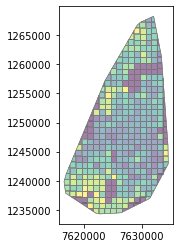

In [7]:
m_plot_dataframe(grid, column='POSITION_POP', contour_poly_width=0.5, edgecolor="grey")

In [70]:
## for polygon centroids
# mtl_parking_stations.geometry = mtl_parking_stations.geometry.centroid
# mtl_parking_stations.plot()

## Space-Time plotting

In [94]:
grid_xy = gpd.read_file("../shapes/grid_stkde.shp")

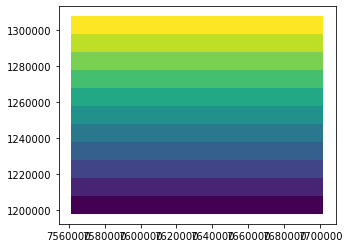

In [100]:
grid_xy.plot('y')

In [77]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

In [178]:
bandwidths = pd.read_csv("../../../../Downloads/localKfunSpaceTime-master/outputs/scale/scale_obs_max.txt",\
                         names=["lower","upper","upper_time","lower_time","upper_space","lower_space"])




In [181]:
bandwidths

lower  upper  upper_time  lower_time  upper_space  lower_space
0     0.0    1.0       111.0       101.0         28.0        478.0
1     1.0    2.0       112.0       102.0         85.0        473.0
2     2.0    3.0       113.0       103.0         74.0        487.0
3     3.0    4.0       114.0       104.0         75.0        487.0
4     4.0    5.0       115.0       105.0         20.0        492.0
5     5.0    6.0       116.0       106.0         21.0        492.0
6     6.0    7.0       117.0       107.0          6.0        506.0
7     7.0    8.0       118.0       108.0         10.0        506.0
8     8.0    9.0       119.0       109.0          8.0        506.0
9     9.0   10.0      1110.0      1010.0          1.0          0.0
10   10.0   11.0      1111.0      1011.0          1.0          0.0
11   11.0   12.0      1112.0      1012.0          1.0          0.0
12   12.0   13.0      1113.0      1013.0          1.0          0.0
13   13.0   14.0      1114.0      1014.0          1.0          0.0

In [164]:
stdke_na = pd.read_csv("../../../../Downloads/densitySpaceTime-master/outFiles/kde_na.txt", names=["x","y","z","value"])

In [165]:
stdke_na.mean()

x          6.998785
y          6.997571
z        381.557287
value     21.018819
dtype: float64

In [172]:
stdke_na.max()

x          9.000000
y          9.000000
z        679.000000
value    131.244701
dtype: float64

In [166]:
stdke_na.x.values

array([5., 5., 5., ..., 9., 9., 9.])

In [167]:
# for u_z in stdke_na.z.unique():
#     grid_xy.merge(stdke_na.loc[stdke_na.z == u_z], how='left').fillna(0).plot('value', cmap='viridis')

In [168]:
stdke_na.head()

x    y    z      value
0  5.0  5.0  138  14.916477
1  5.0  5.0  139  13.637922
2  5.0  5.0  140  11.506996
3  5.0  5.0  141   8.523701
4  5.0  5.0  142   4.688036

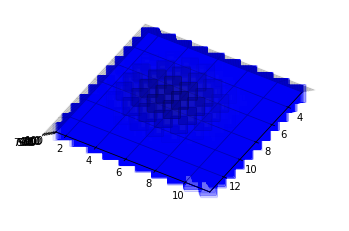

In [150]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(stdke_na.x, stdke_na.y, stdke_na.z, c=stdke_na.value, marker='s',lw=1, s=300, alpha=.005,cmap="bwr")
ax.view_init(90, 30)
plt.show()

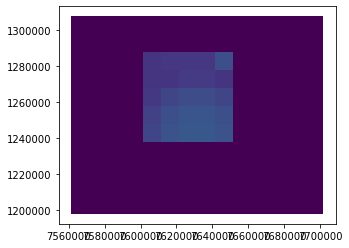

In [169]:
grid_xy.merge(stdke_na[stdke_na.value > 20], how='left').fillna(0).plot('value')

In [171]:
stdke_na[stdke_na.value > 20]

x    y    z      value
8     5.0  5.0  180  24.759322
9     5.0  5.0  181  33.425085
10    5.0  5.0  182  39.614915
11    5.0  5.0  183  43.328813
12    5.0  5.0  184  44.566780
...   ...  ...  ...        ...
4868  9.0  9.0  443  58.285879
4869  9.0  9.0  444  56.479666
4870  9.0  9.0  445  51.385740
4871  9.0  9.0  446  43.004101
4872  9.0  9.0  447  31.334748

[1755 rows x 4 columns]

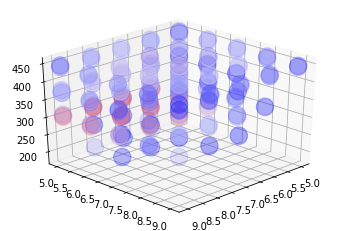

In [175]:
data = stdke_na[stdke_na.value > 50]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(data.x, data.y, data.z, c=data.value, marker='o',lw=1, s=300, alpha=.1,cmap="bwr")
ax.view_init(30, 45)
plt.show()

In [191]:
np.linspace(grid_xy.y.min(),grid_xy.y.max()).shape

(50,)

## ideas from IGS

In [ ]:
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
autocorrelation_plot(winter_df.mean_temp_WNA, label='WNA')
lag_plot(winter_df.mean_temp_Alaska, lag = 1, alpha=.5)